In [1]:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
import zipfile, os

# 1. Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

zip_id = '1z4D3dqqR08X1xyrWOuggN5p404F3vm1v'
print ("Downloading zip file")
myzip = drive.CreateFile({'id': zip_id})
myzip.GetContentFile('model.zip')
print ("Uncompressing zip file")
zip_ref = zipfile.ZipFile('model.zip', 'r')
zip_ref.extractall()
zip_ref.close()

Uncompressing zip file


In [0]:
import zipfile
with zipfile.ZipFile("train_1.csv.zip","r") as zip_ref:
    zip_ref.extractall("")

### Importing all the libraries we will be using for visualization and training

In [0]:
import numpy as np 
import pandas as pd 
import re 
import matplotlib.pyplot as plt
from pandas.plotting import autocorrelation_plot 
from statsmodels.tsa.arima_model import ARIMA 

## Loading the training data as a pandas DataFrame

In [4]:
train_df = pd.read_csv('train_1.csv').fillna(0)
train_df.head()

,Page,2015-07-01,2015-07-02,2015-07-03,2015-07-04,2015-07-05,2015-07-06,2015-07-07,2015-07-08,2015-07-09,2015-07-10,2015-07-11,2015-07-12,2015-07-13,2015-07-14,2015-07-15,2015-07-16,2015-07-17,2015-07-18,2015-07-19,2015-07-20,2015-07-21,2015-07-22,2015-07-23,2015-07-24,2015-07-25,2015-07-26,2015-07-27,2015-07-28,2015-07-29,2015-07-30,2015-07-31,2015-08-01,2015-08-02,2015-08-03,2015-08-04,2015-08-05,2015-08-06,2015-08-07,2015-08-08,...,2016-11-22,2016-11-23,2016-11-24,2016-11-25,2016-11-26,2016-11-27,2016-11-28,2016-11-29,2016-11-30,2016-12-01,2016-12-02,2016-12-03,2016-12-04,2016-12-05,2016-12-06,2016-12-07,2016-12-08,2016-12-09,2016-12-10,2016-12-11,2016-12-12,2016-12-13,2016-12-14,2016-12-15,2016-12-16,2016-12-17,2016-12-18,2016-12-19,2016-12-20,2016-12-21,2016-12-22,2016-12-23,2016-12-24,2016-12-25,2016-12-26,2016-12-27,2016-12-28,2016-12-29,2016-12-30,2016-12-31
0,2NE1_zh.wikipedia.org_all-access_spider,18.0,11.0,5.0,13.0,14.0,9.0,9.0,22.0,26.0,24.0,19.0,10.0,14.0,15.0,8.0,16.0,8.0,8.0,16.0,7.0,11.0,10.0,20.0,18.0,15.0,14.0,49.0,10.0,16.0,18.0,8.0,5.0,9.0,7.0,13.0,9.0,7.0,4.0,11.0,...,24.0,14.0,11.0,204.0,14.0,45.0,33.0,28.0,18.0,14.0,47.0,15.0,14.0,18.0,20.0,14.0,16.0,14.0,20.0,60.0,22.0,15.0,17.0,19.0,18.0,21.0,21.0,47.0,65.0,17.0,32.0,63.0,15.0,26.0,14.0,20.0,22.0,19.0,18.0,20.0
1,2PM_zh.wikipedia.org_all-access_spider,11.0,14.0,15.0,18.0,11.0,13.0,22.0,11.0,10.0,4.0,41.0,65.0,57.0,38.0,20.0,62.0,44.0,15.0,10.0,47.0,24.0,17.0,22.0,9.0,39.0,13.0,11.0,12.0,21.0,19.0,9.0,15.0,33.0,8.0,8.0,7.0,13.0,2.0,23.0,...,14.0,15.0,15.0,11.0,20.0,13.0,19.0,621.0,57.0,17.0,23.0,19.0,21.0,47.0,28.0,22.0,22.0,65.0,27.0,17.0,17.0,13.0,9.0,18.0,22.0,17.0,15.0,22.0,23.0,19.0,17.0,42.0,28.0,15.0,9.0,30.0,52.0,45.0,26.0,20.0
2,3C_zh.wikipedia.org_all-access_spider,1.0,0.0,1.0,1.0,0.0,4.0,0.0,3.0,4.0,4.0,1.0,1.0,1.0,6.0,8.0,6.0,4.0,5.0,1.0,2.0,3.0,8.0,8.0,6.0,6.0,2.0,2.0,3.0,2.0,4.0,3.0,3.0,5.0,3.0,5.0,4.0,2.0,5.0,1.0,...,9.0,3.0,5.0,4.0,0.0,1.0,4.0,5.0,8.0,8.0,1.0,1.0,2.0,5.0,3.0,3.0,3.0,7.0,3.0,9.0,8.0,3.0,210.0,5.0,4.0,6.0,2.0,2.0,4.0,3.0,3.0,1.0,1.0,7.0,4.0,4.0,6.0,3.0,4.0,17.0
3,4minute_zh.wikipedia.org_all-access_spider,35.0,13.0,10.0,94.0,4.0,26.0,14.0,9.0,11.0,16.0,16.0,11.0,23.0,145.0,14.0,17.0,85.0,4.0,30.0,22.0,9.0,10.0,11.0,7.0,7.0,11.0,9.0,11.0,44.0,8.0,14.0,19.0,10.0,17.0,17.0,10.0,7.0,10.0,1.0,...,7.0,10.0,7.0,10.0,14.0,17.0,11.0,9.0,11.0,5.0,10.0,8.0,17.0,13.0,23.0,40.0,16.0,17.0,41.0,17.0,8.0,9.0,18.0,12.0,12.0,18.0,13.0,18.0,23.0,10.0,32.0,10.0,26.0,27.0,16.0,11.0,17.0,19.0,10.0,11.0
4,52_Hz_I_Love_You_zh.wikipedia.org_all-access_s...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,14.0,13.0,15.0,14.0,16.0,9.0,178.0,64.0,12.0,10.0,11.0,6.0,8.0,7.0,9.0,8.0,5.0,11.0,8.0,4.0,15.0,5.0,8.0,8.0,6.0,7.0,15.0,4.0,11.0,7.0,48.0,9.0,25.0,13.0,3.0,11.0,27.0,13.0,36.0,10.0


### Simple code to get the language of any given page

In [0]:
def find_language(url):
    res = re.search('[a-z][a-z].wikipedia.org',url)
    if res:
        return res[0][0:2]
    return 'na'

train_df['lang'] = train_df.Page.map(find_language)

### Here we separate all the pages based on their language and average them up to find views per page per languag

In [0]:
lang_sets = {}
lang_sets['en'] = train_df[train_df.lang=='en'].iloc[:,0:-1]
lang_sets['ja'] = train_df[train_df.lang=='ja'].iloc[:,0:-1]
lang_sets['de'] = train_df[train_df.lang=='de'].iloc[:,0:-1]
lang_sets['na'] = train_df[train_df.lang=='na'].iloc[:,0:-1]
lang_sets['fr'] = train_df[train_df.lang=='fr'].iloc[:,0:-1]
lang_sets['zh'] = train_df[train_df.lang=='zh'].iloc[:,0:-1]
lang_sets['ru'] = train_df[train_df.lang=='ru'].iloc[:,0:-1]
lang_sets['es'] = train_df[train_df.lang=='es'].iloc[:,0:-1]

sums = {}
for key in lang_sets:
    sums[key] = lang_sets[key].iloc[:,1:].sum(axis=0) / lang_sets[key].shape[0]

### Plots of average number of views for all different languages per day 

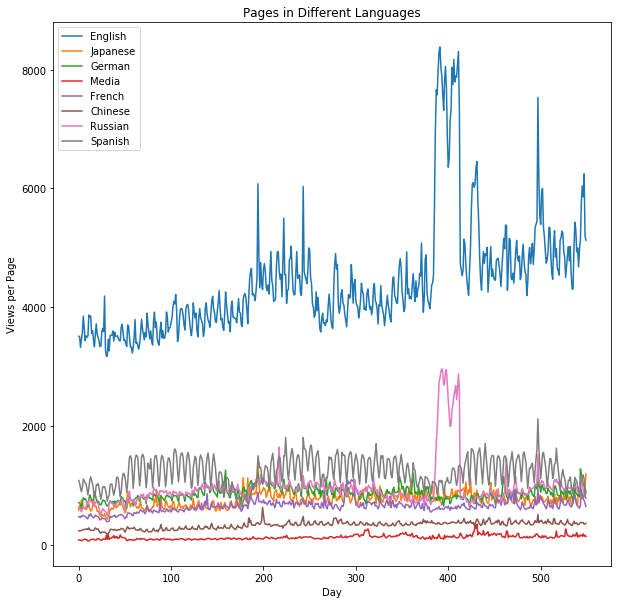

In [7]:
days = [r for r in range(sums['en'].shape[0])]

fig = plt.figure(1,figsize=[10,10])
plt.ylabel('Views per Page')
plt.xlabel('Day')
plt.title('Pages in Different Languages')
labels={'en':'English','ja':'Japanese','de':'German',
        'na':'Media','fr':'French','zh':'Chinese',
        'ru':'Russian','es':'Spanish'
       }

for key in sums:
    plt.plot(days,sums[key],label = labels[key] )
    
plt.legend()
plt.show()


### Now we can plot Autocorrelation and Partial Autocorrelation graphs for all these languages, to estimate the hyperparameters used in training the ARIMA model.

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/stattools.py:541: FutureWarning: fft=True will become the default in a future version of statsmodels. To suppress this warning, explicitly set fft=False.
  warnings.warn(msg, FutureWarning)


en


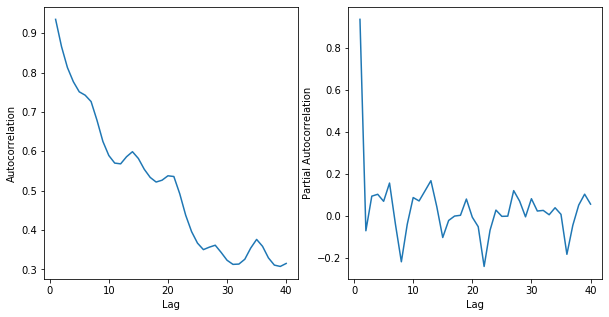

ja


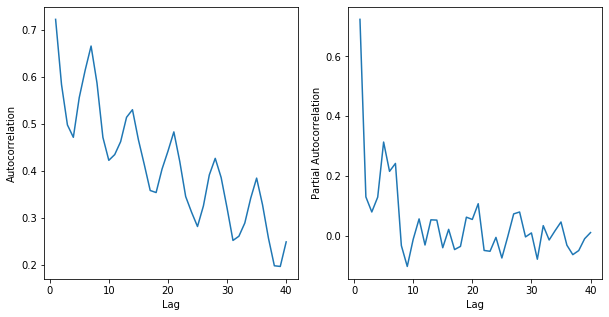

de


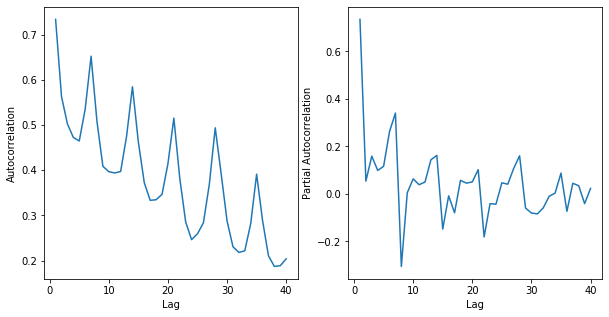

na


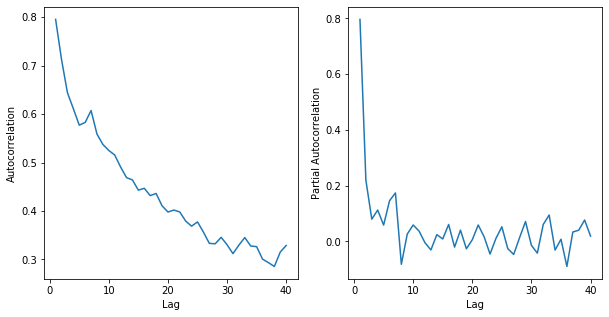

fr


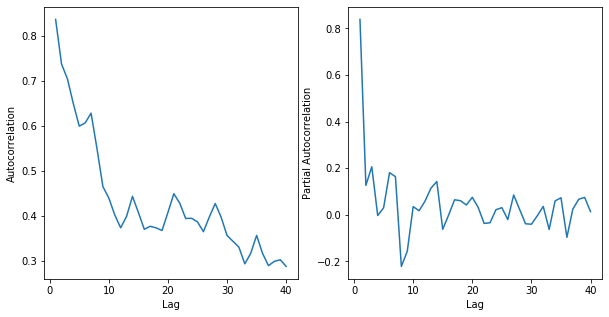

zh


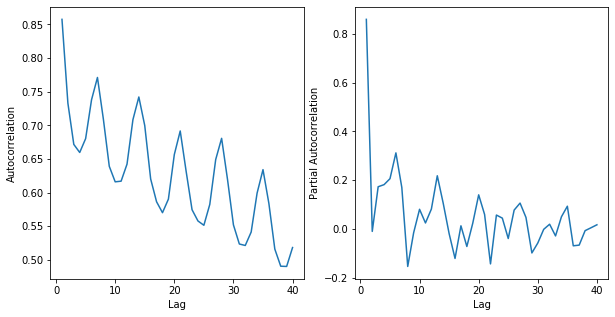

ru


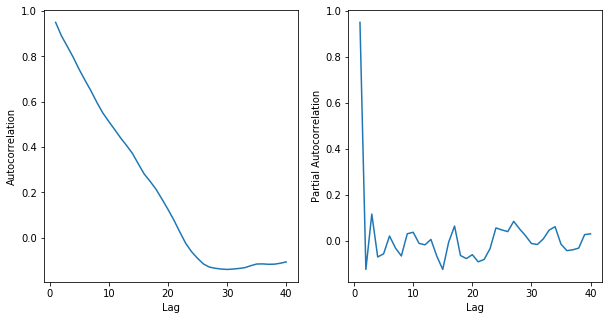

es


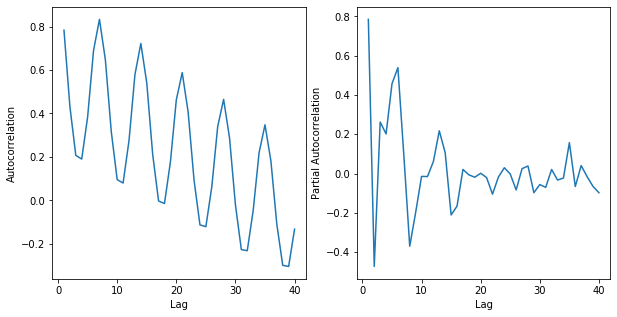

In [8]:
from statsmodels.tsa.stattools import pacf
from statsmodels.tsa.stattools import acf

for key in sums:
    fig = plt.figure(1,figsize=[10,5])
    ax1 = fig.add_subplot(121)
    ax2 = fig.add_subplot(122)
    data = np.array(sums[key])
    autocorr = acf(data)
    pac = pacf(data)

    x = [x for x in range(len(pac))]
    ax1.plot(x[1:],autocorr[1:])

    ax2.plot(x[1:],pac[1:])
    ax1.set_xlabel('Lag')
    ax1.set_ylabel('Autocorrelation')

    ax2.set_xlabel('Lag')
    ax2.set_ylabel('Partial Autocorrelation')
    print(key)
    plt.show()

### Looking at all these graphs we conclude
 1. We won't be needing any differencing for en, ru, fr, na (d=0). For the others we need to subtract them once from their predecessor (d=1).
 2. For ja, de, zh, es there is a trend of peaks after 7 days. Thus a lag of 7 might be used and for the rest a lag of 4 should work okay.

## Now we will be training ARIMA models for different languages

We tune in the parameters discussed above and train our ARIMA models as follows:

en


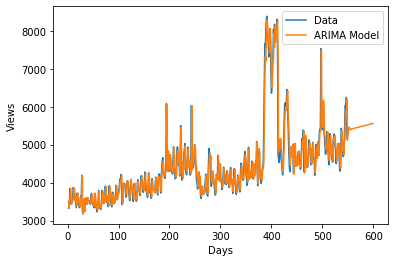

ja


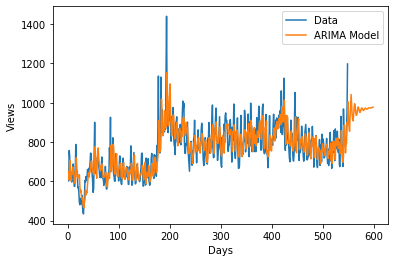

de


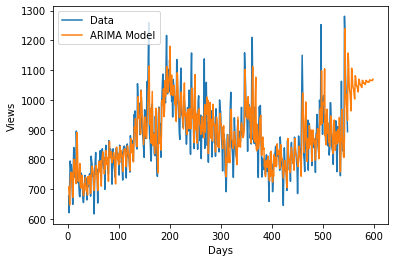

na


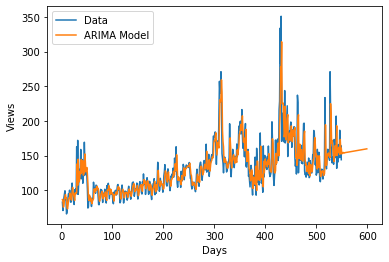

fr


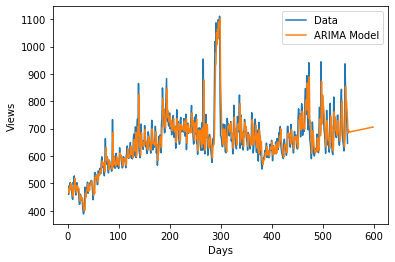

zh


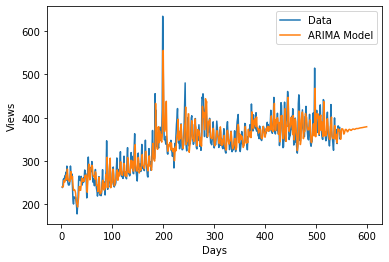

ru


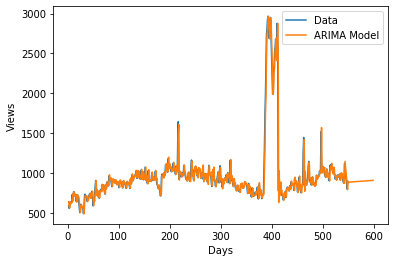

es


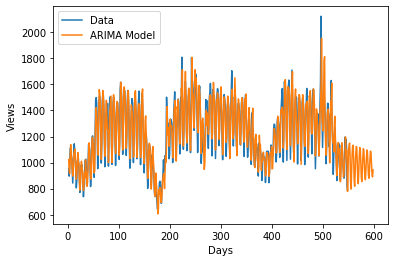

In [9]:
params = {'en': [4,1,0], 'ja': [7,1,1], 'de': [7,1,1], 'na': [4,1,0], 'fr': [4,1,0], 'zh': [7,1,1], 'ru': [4,1,0], 'es': [7,1,1]}

for key in sums:
    data = np.array(sums[key])
    result = None
    arima = ARIMA(data,params[key])
    result = arima.fit(disp=False)
    #print(result.params)
    pred = result.predict(2,599,typ='levels')
    x = [i for i in range(600)]
    i=0
    
    print(key)
    plt.plot(x[2:len(data)],data[2:] ,label='Data')
    plt.plot(x[2:],pred,label='ARIMA Model')
    plt.xlabel('Days')
    plt.ylabel('Views')
    plt.legend()
    plt.show()


### We will be training LSTM models for top pages of all the languages as a demo

In [10]:
train_df = train_df.drop('Page',axis = 1)
train_df.shape

(145063, 551)

In [11]:
#Packages for pre processing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

 # Importing the Keras libraries and packages for LSTM
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

Using TensorFlow backend.






Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where








en


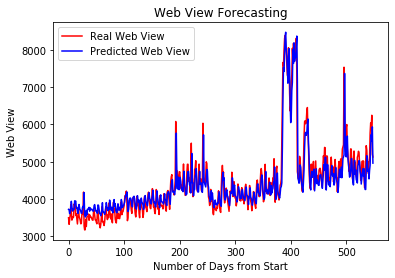

ja


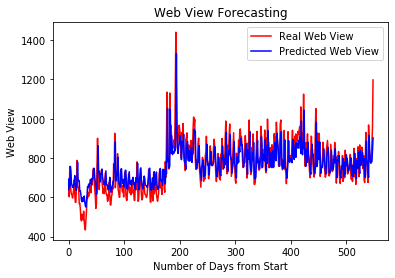

de


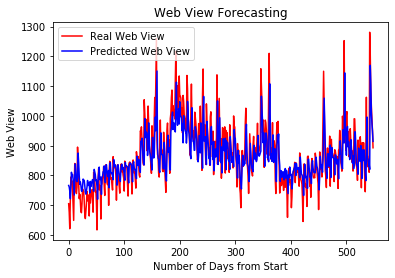

na


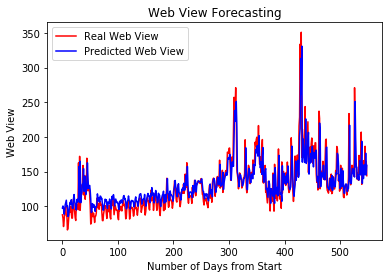

fr


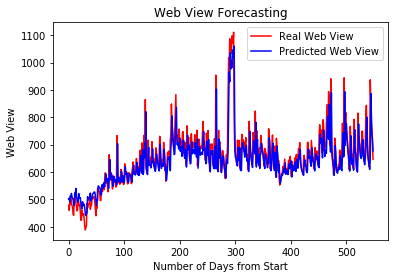

zh


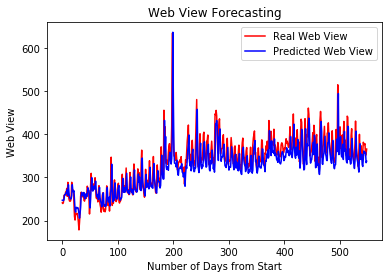

ru


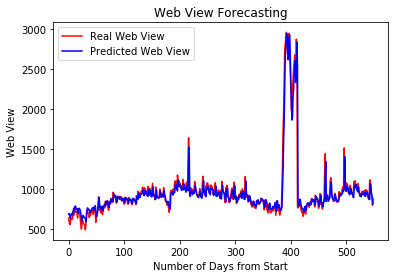

es


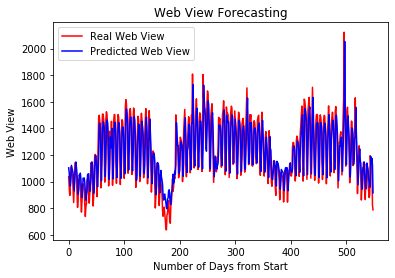

In [12]:
 for key in sums:
    row = [0]*sums[key].shape[0]
    for i in range(sums[key].shape[0]):
        row[i] = sums[key][i]


    #Using Data From Random Row for Training and Testing

    X = row[0:549]
    y = row[1:550]

    # Splitting the dataset into the Training set and Test set
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 0)

    # Feature Scaling
    sc = MinMaxScaler()
    X_train = np.reshape(X_train,(-1,1))
    y_train = np.reshape(y_train,(-1,1))
    X_train = sc.fit_transform(X_train)
    y_train = sc.fit_transform(y_train)


    #Training LSTM

    #Reshaping Array
    X_train = np.reshape(X_train, (384,1,1))

    # Initialising the RNN
    regressor = Sequential()

    # Adding the input layerand the LSTM layer
    regressor.add(LSTM(units = 8, activation = 'relu', input_shape = (None, 1)))


    # Adding the output layer
    regressor.add(Dense(units = 1))

    # Compiling the RNN
    regressor.compile(optimizer = 'rmsprop', loss = 'mean_squared_error')

    # Fitting the RNN to the Training set
    regressor.fit(X_train, y_train, batch_size = 10, epochs = 100, verbose = 0)

    # Getting the predicted Web View
    inputs = X
    inputs = np.reshape(inputs,(-1,1))
    inputs = sc.transform(inputs)
    inputs = np.reshape(inputs, (549,1,1))
    y_pred = regressor.predict(inputs)
    y_pred = sc.inverse_transform(y_pred)

    print(key)
    #Visualising Result
    plt.figure
    plt.plot(y, color = 'red', label = 'Real Web View')
    plt.plot(y_pred, color = 'blue', label = 'Predicted Web View')
    plt.title('Web View Forecasting')
    plt.xlabel('Number of Days from Start')
    plt.ylabel('Web View')
    plt.legend()
    plt.show()